##  1. Import Libraries and Setup

In [8]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                           ConfusionMatrixDisplay, accuracy_score, 
                           precision_score, recall_score, f1_score,
                           silhouette_score)

# Visualization
from wordcloud import WordCloud

# Set style for better plots
plt.style.use('default')  # Cambiado de seaborn a default
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Define a nice color palette manually
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#D63031', '#74B9FF']

##  2. Database Connection and Data Exploration

In [9]:
def connect_to_database(db_path):
    """Connect to SQLite database and return connection object."""
    try:
        conn = sqlite3.connect(db_path)
        print(f"✅ Successfully connected to database: {db_path}")
        return conn
    except sqlite3.Error as e:
        print(f"❌ Error connecting to database: {e}")
        return None

def explore_database_structure(conn):
    """Explore database structure and show table information."""
    cursor = conn.cursor()
    
    # Get all tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("📋 Available tables:")
    for table in tables:
        print(f"  - {table[0]}")
    
    # Explore submission table
    cursor.execute("PRAGMA table_info(submission);")
    print("\n🏗️ Submission table structure:")
    for column in cursor.fetchall():
        print(f"  - {column[1]} ({column[2]})")
    
    # Explore comment table
    cursor.execute("PRAGMA table_info(comment);")
    print("\n💬 Comment table structure:")
    for column in cursor.fetchall():
        print(f"  - {column[1]} ({column[2]})")

In [10]:
# CAMBIA ESTA RUTA POR LA RUTA CORRECTA DE TU BASE DE DATOS
DB_PATH = "/Users/michaelmoreno/Downloads/isis4219-aita-project-main/src/notebooks/data/AmItheAsshole.sqlite"

conn = connect_to_database(DB_PATH)

if conn:
    explore_database_structure(conn)

✅ Successfully connected to database: /Users/michaelmoreno/Downloads/isis4219-aita-project-main/src/notebooks/data/AmItheAsshole.sqlite
📋 Available tables:
  - submission
  - comment

🏗️ Submission table structure:
  - id (INTEGER)
  - submission_id (VARCHAR(255))
  - title (TEXT)
  - selftext (TEXT)
  - created_utc (DATE)
  - permalink (TEXT)
  - score (INTEGER)

💬 Comment table structure:
  - id (INTEGER)
  - submission_id (INTEGER)
  - message (TEXT)
  - comment_id (VARCHAR(255))
  - parent_id (VARCHAR(255))
  - created_utc (DATE)
  - score (INTEGER)


##  3. Data Loading and Initial Exploration

In [11]:
def load_data(conn, sample_size=None):
    """Load submissions and comments data from database."""
    
    # Load submissions
    if sample_size:
        submissions_query = f"SELECT submission_id, title, selftext FROM submission LIMIT {sample_size};"
    else:
        submissions_query = "SELECT submission_id, title, selftext FROM submission;"
    
    df_submissions = pd.read_sql_query(submissions_query, conn)
    
    # Load comments
    df_comments = pd.read_sql_query("SELECT submission_id, message FROM comment;", conn)
    
    print(f"📊 Data loaded successfully:")
    print(f"  - Submissions: {len(df_submissions):,}")
    print(f"  - Comments: {len(df_comments):,}")
    
    return df_submissions, df_comments

def show_sample_data(df_submissions, df_comments, n=3):
    """Display sample data for understanding."""
    print("\n🔍 Sample submissions:")
    print(df_submissions.head(n)[['title', 'selftext']].to_string())
    
    print("\n💭 Sample comments:")
    print(df_comments.head(n)['message'].to_string())

In [12]:
# Load data
df_submissions, df_comments = load_data(conn)
show_sample_data(df_submissions, df_comments)

📊 Data loaded successfully:
  - Submissions: 30,994
  - Comments: 9,101,374

🔍 Sample submissions:
                                                                                                     title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## 4. Verdict Extraction and Data Preprocessing

In [13]:
def extract_verdict(message):
    """Extract verdict from comment message."""
    if pd.isna(message):
        return None
    
    message = str(message).upper()
    verdict_keywords = ['NTA', 'YTA', 'ESH', 'NAH', 'INFO']
    
    # Look for exact word matches
    words = message.split()
    for word in verdict_keywords:
        if word in words:
            return word
    return None

def process_verdicts(df_comments):
    """Process comments to extract verdicts and aggregate by submission."""
    print("🔍 Extracting verdicts from comments...")
    
    # Extract verdicts
    df_comments['label'] = df_comments['message'].apply(extract_verdict)
    
    # Remove comments without verdicts
    df_comments_labeled = df_comments[df_comments['label'].notnull()].copy()
    print(f"  - Comments with verdicts: {len(df_comments_labeled):,}")
    
    # Show verdict distribution
    verdict_counts = df_comments_labeled['label'].value_counts()
    print("\n📊 Verdict distribution in comments:")
    for verdict, count in verdict_counts.items():
        print(f"  - {verdict}: {count:,} ({count/len(df_comments_labeled)*100:.1f}%)")
    
    # Aggregate verdicts by submission (most common verdict wins)
    submission_verdicts = (df_comments_labeled
                          .groupby('submission_id')['label']
                          .apply(lambda x: Counter(x).most_common(1)[0][0])
                          .reset_index())
    
    print(f"\n🎯 Submissions with determined verdicts: {len(submission_verdicts):,}")
    return submission_verdicts

🔍 Extracting verdicts from comments...
  - Comments with verdicts: 1,950,942

📊 Verdict distribution in comments:
  - NTA: 1,263,635 (64.8%)
  - YTA: 531,750 (27.3%)
  - ESH: 72,717 (3.7%)
  - NAH: 45,047 (2.3%)
  - INFO: 37,793 (1.9%)

🎯 Submissions with determined verdicts: 30,791


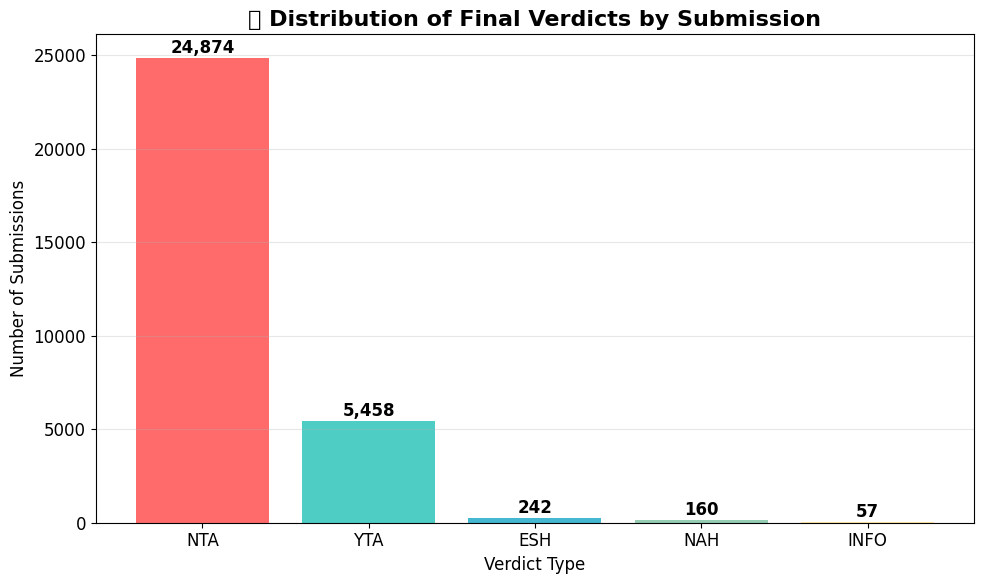

In [14]:
# Process verdicts
submission_verdicts = process_verdicts(df_comments)

# Visualize verdict distribution
plt.figure(figsize=(10, 6))
verdict_counts = submission_verdicts['label'].value_counts()
bars = plt.bar(verdict_counts.index, verdict_counts.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
plt.title('🏷️ Distribution of Final Verdicts by Submission', fontsize=16, fontweight='bold')
plt.xlabel('Verdict Type', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Merging and Preparation

In [15]:
def merge_and_prepare_data(df_submissions, submission_verdicts):
    """Merge submissions with verdicts and prepare text data."""
    
    # Merge datasets
    df_merged = df_submissions.merge(submission_verdicts, on='submission_id', how='inner')
    print(f"📋 Merged dataset size: {len(df_merged):,} submissions")
    
    # Combine title and selftext
    df_merged['text'] = (df_merged['title'].fillna('') + ' ' + 
                        df_merged['selftext'].fillna('')).str.strip()
    
    # Remove empty texts
    df_merged = df_merged[df_merged['text'].str.len() > 10].copy()
    print(f"  - After removing short texts: {len(df_merged):,}")
    
    # Show text length statistics
    text_lengths = df_merged['text'].str.len()
    print(f"\n📏 Text length statistics:")
    print(f"  - Mean: {text_lengths.mean():.0f} characters")
    print(f"  - Median: {text_lengths.median():.0f} characters")
    print(f"  - Min: {text_lengths.min():.0f} characters")
    print(f"  - Max: {text_lengths.max():.0f} characters")
    
    return df_merged

def balance_dataset(df_merged, strategy='downsample'):
    """Balance the dataset to handle class imbalance."""
    
    print(f"\n⚖️ Balancing dataset using {strategy} strategy...")
    
    # Show original distribution
    original_counts = df_merged['label'].value_counts()
    print("Original distribution:")
    for label, count in original_counts.items():
        print(f"  - {label}: {count:,}")
    
    if strategy == 'downsample':
        # Downsample majority class (NTA) to match minority classes
        df_majority = df_merged[df_merged['label'] == 'NTA']
        df_minority = df_merged[df_merged['label'] != 'NTA']
        
        # Downsample majority class
        df_majority_downsampled = resample(
            df_majority, 
            replace=False,    
            n_samples=len(df_minority),
            random_state=42
        )
        
        # Combine datasets
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
        
    elif strategy == 'upsample':
        # Upsample minority classes to match majority class
        df_majority = df_merged[df_merged['label'] == 'NTA']
        df_minorities = []
        
        for label in df_merged['label'].unique():
            if label != 'NTA':
                df_minority = df_merged[df_merged['label'] == label]
                df_minority_upsampled = resample(
                    df_minority,
                    replace=True,
                    n_samples=len(df_majority),
                    random_state=42
                )
                df_minorities.append(df_minority_upsampled)
        
        df_balanced = pd.concat([df_majority] + df_minorities)
    
    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Show balanced distribution
    balanced_counts = df_balanced['label'].value_counts()
    print("\nBalanced distribution:")
    for label, count in balanced_counts.items():
        print(f"  - {label}: {count:,}")
    
    return df_balanced

📋 Merged dataset size: 30,752 submissions
  - After removing short texts: 30,752

📏 Text length statistics:
  - Mean: 2074 characters
  - Median: 2008 characters
  - Min: 31 characters
  - Max: 9252 characters

⚖️ Balancing dataset using downsample strategy...
Original distribution:
  - NTA: 24,845
  - YTA: 5,449
  - ESH: 241
  - NAH: 160
  - INFO: 57

Balanced distribution:
  - NTA: 5,907
  - YTA: 5,449
  - ESH: 241
  - NAH: 160
  - INFO: 57


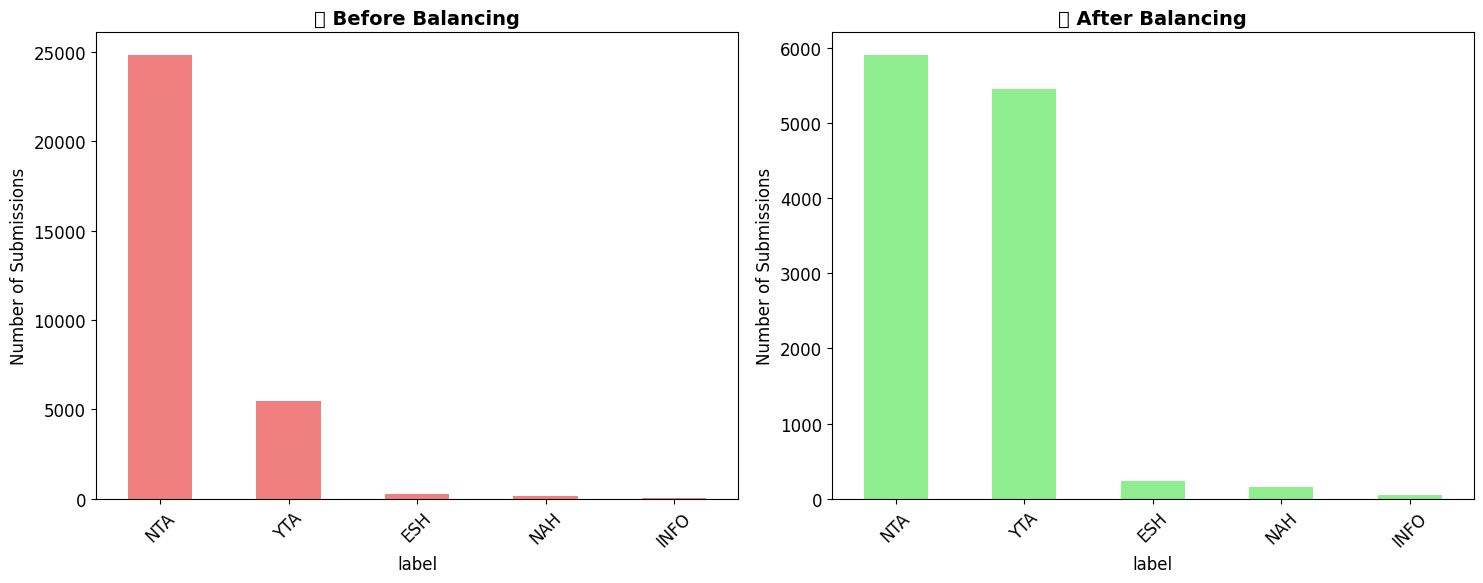

In [16]:
# Merge and prepare data
df_merged = merge_and_prepare_data(df_submissions, submission_verdicts)

# Balance dataset
df_balanced = balance_dataset(df_merged, strategy='downsample')

# Visualize before and after balancing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before balancing
df_merged['label'].value_counts().plot(kind='bar', ax=ax1, color='lightcoral')
ax1.set_title('🔴 Before Balancing', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Submissions')
ax1.tick_params(axis='x', rotation=45)

# After balancing
df_balanced['label'].value_counts().plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('🟢 After Balancing', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Submissions')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

##  6. Text Vectorization with TF-IDF

In [17]:
def create_tfidf_features(X_train, X_test, max_features=20000):
    """Create TF-IDF features from text data."""
    
    print(f"🔤 Creating TF-IDF features (max_features={max_features:,})...")
    
    # Initialize vectorizer
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=max_features,
        ngram_range=(1, 2),  # Include unigrams and bigrams
        min_df=2,            # Ignore terms that appear in less than 2 documents
        max_df=0.95          # Ignore terms that appear in more than 95% of documents
    )
    
    # Fit and transform training data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    print(f"  - Training set shape: {X_train_vec.shape}")
    print(f"  - Test set shape: {X_test_vec.shape}")
    print(f"  - Vocabulary size: {len(vectorizer.vocabulary_):,}")
    
    return vectorizer, X_train_vec, X_test_vec

# Prepare features and labels
X = df_balanced['text']
y = df_balanced['label']

print(f"🎯 Preparing ML features:")
print(f"  - Total samples: {len(X):,}")
print(f"  - Unique labels: {y.nunique()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"  - Training samples: {len(X_train):,}")
print(f"  - Test samples: {len(X_test):,}")

# Create TF-IDF features
vectorizer, X_train_vec, X_test_vec = create_tfidf_features(X_train, X_test)

🎯 Preparing ML features:
  - Total samples: 11,814
  - Unique labels: 5
  - Training samples: 9,451
  - Test samples: 2,363
🔤 Creating TF-IDF features (max_features=20,000)...
  - Training set shape: (9451, 20000)
  - Test set shape: (2363, 20000)
  - Vocabulary size: 20,000


## 7. K-Means Clustering Analysis

In [18]:
def find_optimal_clusters(X_vec, max_k=10):
    """Find optimal number of clusters using silhouette score."""
    
    print("🔍 Finding optimal number of clusters...")
    
    silhouette_scores = []
    k_values = range(2, max_k + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_vec)
        score = silhouette_score(X_vec, labels)
        silhouette_scores.append(score)
        print(f"  - k={k}: Silhouette Score = {score:.4f}")
    
    # Find optimal k
    optimal_k = k_values[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)
    
    print(f"\n🎯 Optimal k = {optimal_k} (Silhouette Score = {optimal_score:.4f})")
    
    # Visualize scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o', linewidth=2, markersize=8)
    plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal k = {optimal_k}')
    plt.title('📊 Silhouette Score vs Number of Clusters', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.xticks(k_values)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return optimal_k, silhouette_scores

def perform_clustering(X_vec, k=5):
    """Perform K-means clustering and return results."""
    
    print(f"🎯 Performing K-means clustering with k={k}...")
    
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_vec)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_vec, clusters)
    print(f"  - Silhouette Score: {sil_score:.4f}")
    print(f"  - Unique clusters: {np.unique(clusters)}")
    
    return kmeans, clusters, sil_score

🔍 Finding optimal number of clusters...
  - k=2: Silhouette Score = 0.0019
  - k=3: Silhouette Score = 0.0030
  - k=4: Silhouette Score = 0.0043
  - k=5: Silhouette Score = 0.0041
  - k=6: Silhouette Score = 0.0044
  - k=7: Silhouette Score = 0.0050
  - k=8: Silhouette Score = 0.0054
  - k=9: Silhouette Score = 0.0058
  - k=10: Silhouette Score = 0.0061

🎯 Optimal k = 10 (Silhouette Score = 0.0061)


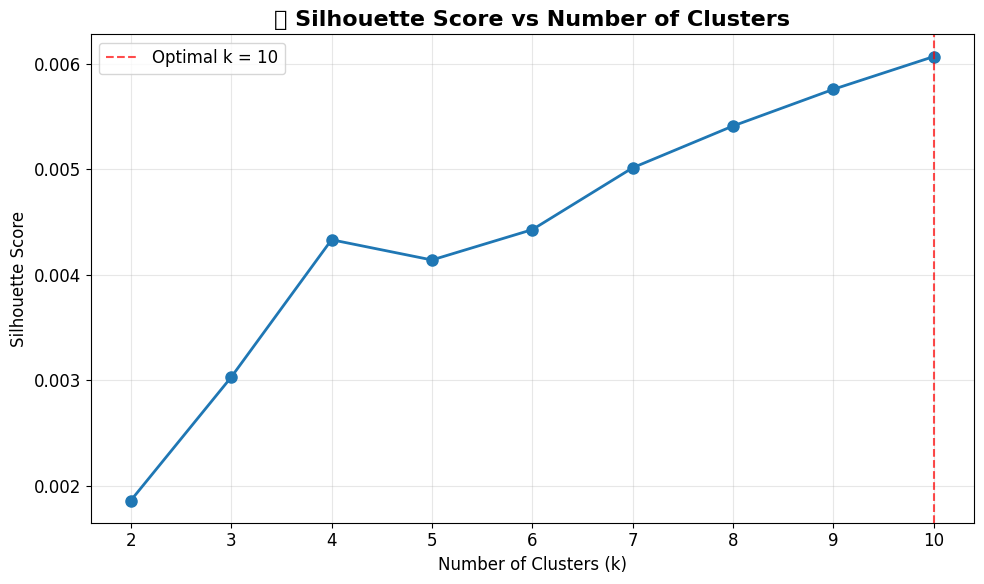

🎯 Performing K-means clustering with k=10...
  - Silhouette Score: 0.0061
  - Unique clusters: [0 1 2 3 4 5 6 7 8 9]


In [19]:
# Find optimal number of clusters
optimal_k, scores = find_optimal_clusters(X_train_vec, max_k=10)

# Perform clustering with optimal k
kmeans, train_clusters, sil_score = perform_clustering(X_train_vec, k=optimal_k)

# Get test clusters
test_clusters = kmeans.predict(X_test_vec)

##  8. Cluster Visualization

🎨 Creating cluster visualization...


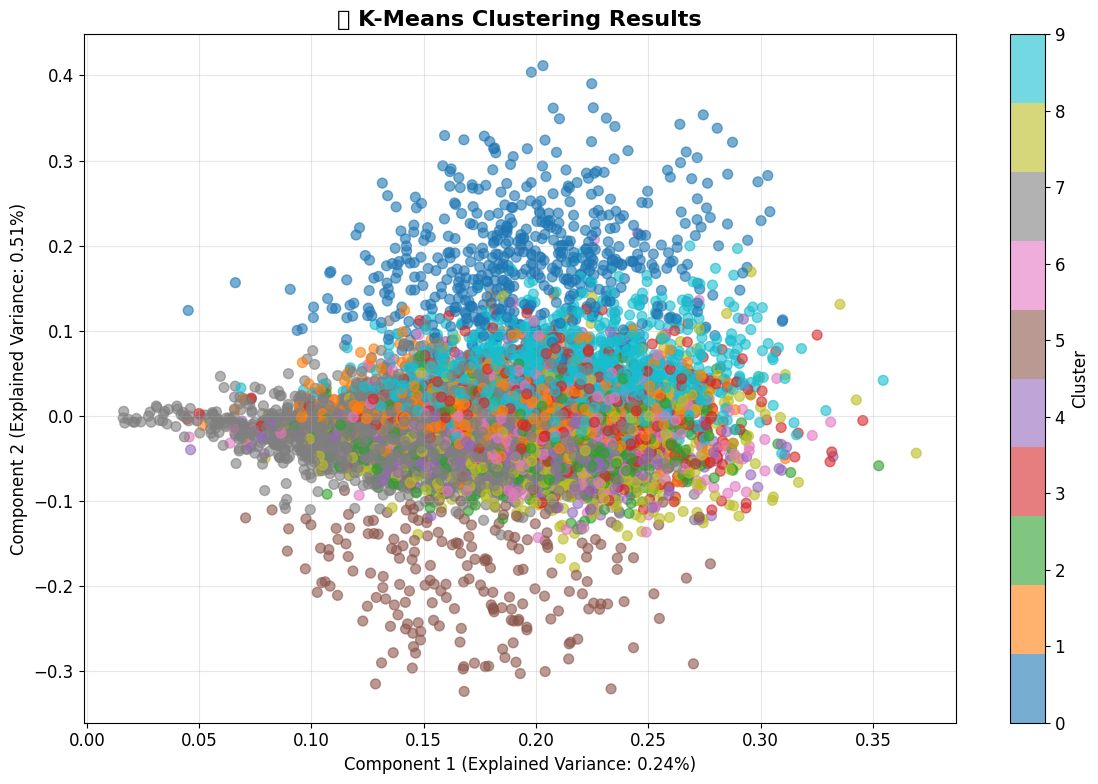

  - Total explained variance: 0.75%


In [20]:
def visualize_clusters(X_vec, clusters, title="Cluster Visualization"):
    """Visualize clusters in 2D using dimensionality reduction."""
    
    print("🎨 Creating cluster visualization...")
    
    # Reduce to 2 dimensions using SVD
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_reduced = svd.fit_transform(X_vec)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                         c=clusters, cmap='tab10', alpha=0.6, s=50)
    plt.title(f'🌟 {title}', fontsize=16, fontweight='bold')
    plt.xlabel(f'Component 1 (Explained Variance: {svd.explained_variance_ratio_[0]:.2%})', fontsize=12)
    plt.ylabel(f'Component 2 (Explained Variance: {svd.explained_variance_ratio_[1]:.2%})', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster', fontsize=12)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"  - Total explained variance: {sum(svd.explained_variance_ratio_):.2%}")
    
    return X_reduced

# Visualize clusters
X_reduced = visualize_clusters(X_train_vec, train_clusters, "K-Means Clustering Results")

## 9. Cluster Analysis and Word Clouds

In [21]:
def analyze_cluster_words(vectorizer, kmeans, n_top_words=15):
    """Analyze and display top words for each cluster."""
    
    print(f"🔍 Analyzing top {n_top_words} words per cluster...")
    
    terms = vectorizer.get_feature_names_out()
    
    for i, center in enumerate(kmeans.cluster_centers_):
        print(f"\n🌀 Cluster {i}:")
        top_indices = center.argsort()[::-1][:n_top_words]
        top_terms = [terms[ind] for ind in top_indices]
        top_weights = [center[ind] for ind in top_indices]
        
        for term, weight in zip(top_terms, top_weights):
            print(f"  - {term}: {weight:.4f}")

def create_cluster_wordclouds(vectorizer, X_vec, clusters, n_clusters):
    """Create word clouds for each cluster."""
    
    print("☁️ Creating word clouds for each cluster...")
    
    terms = vectorizer.get_feature_names_out()
    
    # Calculate word weights for each cluster
    cluster_word_weights = {}
    
    for i in range(n_clusters):
        cluster_indices = np.where(clusters == i)[0]
        if len(cluster_indices) == 0:
            cluster_word_weights[i] = {}
            continue
            
        cluster_tfidf = X_vec[cluster_indices]
        summed = cluster_tfidf.sum(axis=0)
        word_weights = np.asarray(summed).flatten()
        
        # Create dictionary of word weights
        filtered_weights = {
            term: weight for term, weight in zip(terms, word_weights)
            if not np.isnan(weight) and weight > 0
        }
        
        cluster_word_weights[i] = filtered_weights
    
    # Create word clouds
    fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))
    if n_clusters == 1:
        axes = [axes]
    
    for i in range(n_clusters):
        freqs = cluster_word_weights[i]
        
        if len(freqs) == 0:
            print(f"⚠️ Cluster {i} has insufficient words for word cloud.")
            axes[i].axis('off')
            axes[i].set_title(f'Cluster {i} (empty)')
            continue
        
        wordcloud = WordCloud(
            width=800, height=400, 
            background_color='white',
            colormap='viridis'
        ).generate_from_frequencies(freqs)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'🌀 Cluster {i}', fontsize=14, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

🔍 Analyzing top 10 words per cluster...

🌀 Cluster 0:
  - wedding: 0.2187
  - dress: 0.0530
  - sister: 0.0397
  - family: 0.0396
  - married: 0.0338
  - fiancé: 0.0282
  - said: 0.0281
  - brother: 0.0276
  - told: 0.0268
  - just: 0.0243

🌀 Cluster 1:
  - friend: 0.0767
  - friends: 0.0542
  - said: 0.0342
  - just: 0.0314
  - told: 0.0311
  - like: 0.0305
  - didn: 0.0272
  - really: 0.0243
  - girlfriend: 0.0228
  - aita: 0.0217

🌀 Cluster 2:
  - money: 0.0875
  - pay: 0.0729
  - car: 0.0525
  - rent: 0.0487
  - house: 0.0342
  - job: 0.0324
  - said: 0.0278
  - paying: 0.0263
  - told: 0.0251
  - work: 0.0243

🌀 Cluster 3:
  - husband: 0.1371
  - kids: 0.0484
  - baby: 0.0385
  - mil: 0.0333
  - family: 0.0325
  - told: 0.0322
  - said: 0.0285
  - just: 0.0265
  - home: 0.0251
  - time: 0.0244

🌀 Cluster 4:
  - son: 0.2088
  - said: 0.0355
  - told: 0.0315
  - ex: 0.0306
  - husband: 0.0302
  - wife: 0.0262
  - just: 0.0239
  - kids: 0.0225
  - didn: 0.0214
  - aita: 0.0211

🌀 Clu

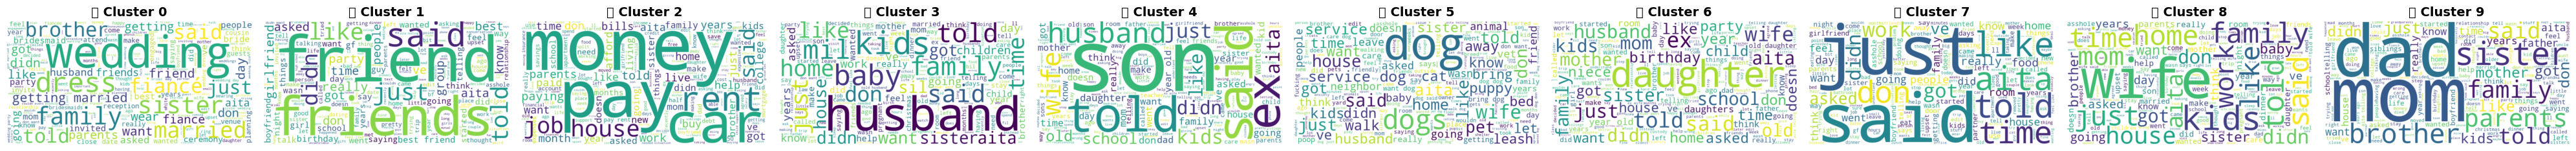

In [22]:
# Analyze cluster words
analyze_cluster_words(vectorizer, kmeans, n_top_words=10)

# Create word clouds
create_cluster_wordclouds(vectorizer, X_train_vec, train_clusters, optimal_k)

##  10. SVM Classification

In [23]:
def train_svm_model(X_train_vec, y_train, kernel='rbf', C=1.0):
    """Train SVM model with specified parameters."""
    
    print(f"🤖 Training SVM model (kernel={kernel}, C={C})...")
    
    model = SVC(kernel=kernel, C=C, random_state=42, gamma='scale')
    model.fit(X_train_vec, y_train)
    
    print("✅ Model trained successfully!")
    return model

def evaluate_model(model, X_test_vec, y_test, model_name="SVM"):
    """Evaluate model performance."""
    
    print(f"\n📊 Evaluating {model_name} model...")
    
    # Make predictions
    y_pred = model.predict(X_test_vec)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"🎯 Performance Metrics:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1-Score: {f1:.4f}")
    
    # Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return y_pred, accuracy, precision, recall, f1

def plot_confusion_matrix(y_test, y_pred, model_name="SVM"):
    """Plot confusion matrix."""
    
    print(f"📊 Creating confusion matrix for {model_name}...")
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"🎯 Confusion Matrix - {model_name}", fontsize=16, fontweight='bold')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

🤖 Training SVM model (kernel=rbf, C=1.0)...
✅ Model trained successfully!

📊 Evaluating SVM (RBF) model...
🎯 Performance Metrics:
  - Accuracy: 0.6085
  - Precision: 0.5852
  - Recall: 0.6085
  - F1-Score: 0.5950

📋 Detailed Classification Report:
              precision    recall  f1-score   support

         ESH       0.00      0.00      0.00        48
        INFO       0.00      0.00      0.00        11
         NAH       0.00      0.00      0.00        32
         NTA       0.61      0.70      0.65      1182
         YTA       0.61      0.57      0.59      1090

    accuracy                           0.61      2363
   macro avg       0.24      0.25      0.25      2363
weighted avg       0.59      0.61      0.60      2363

📊 Creating confusion matrix for SVM (RBF)...


<Figure size 800x600 with 0 Axes>

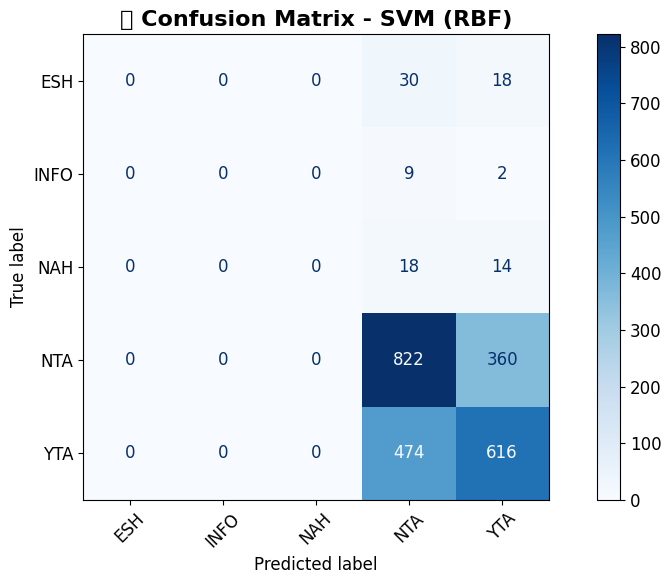

In [24]:
# Train SVM model with RBF kernel
svm_model = train_svm_model(X_train_vec, y_train, kernel='rbf', C=1.0)

# Evaluate model
y_pred, accuracy, precision, recall, f1 = evaluate_model(svm_model, X_test_vec, y_test, "SVM (RBF)")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, "SVM (RBF)")

##  11. Comparison of Different SVM Kernels

🔄 Comparing different SVM kernels...

🧪 Testing kernel: linear
  - Accuracy: 0.6043
  - Precision: 0.5807
  - Recall: 0.6043
  - F1-Score: 0.5920

🧪 Testing kernel: rbf
  - Accuracy: 0.6085
  - Precision: 0.5852
  - Recall: 0.6085
  - F1-Score: 0.5950

🧪 Testing kernel: poly
  - Accuracy: 0.5569
  - Precision: 0.5515
  - Recall: 0.5569
  - F1-Score: 0.5103
📊 Creating kernel comparison visualization...


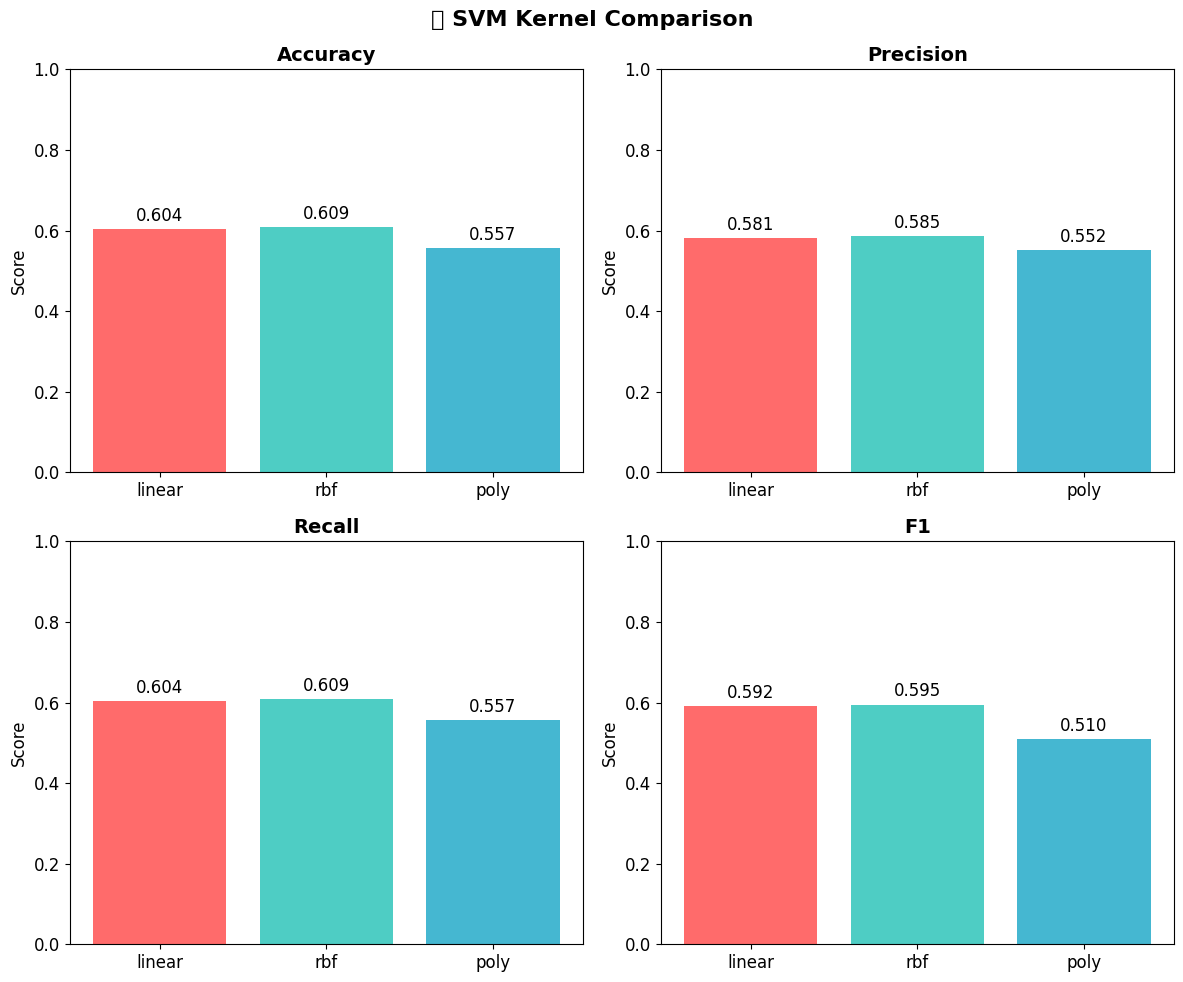

In [25]:
def compare_svm_kernels(X_train_vec, y_train, X_test_vec, y_test):
    """Compare different SVM kernels."""
    
    print("🔄 Comparing different SVM kernels...")
    
    kernels = ['linear', 'rbf', 'poly']
    results = {}
    
    for kernel in kernels:
        print(f"\n🧪 Testing kernel: {kernel}")
        
        # Train model
        model = SVC(kernel=kernel, C=1.0, random_state=42, gamma='scale')
        model.fit(X_train_vec, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_vec)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results[kernel] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Precision: {precision:.4f}")
        print(f"  - Recall: {recall:.4f}")
        print(f"  - F1-Score: {f1:.4f}")
    
    return results

def plot_kernel_comparison(results):
    """Plot comparison of different kernels."""
    
    print("📊 Creating kernel comparison visualization...")
    
    kernels = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        values = [results[kernel][metric] for kernel in kernels]
        bars = axes[i].bar(kernels, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[i].set_title(f'{metric.capitalize()}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel('Score')
        axes[i].set_ylim(0, 1)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom')
    
    plt.suptitle('🔄 SVM Kernel Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Compare kernels
kernel_results = compare_svm_kernels(X_train_vec, y_train, X_test_vec, y_test)

# Plot comparison
plot_kernel_comparison(kernel_results)

## 12. Cross-Validation and Model Selection

🔄 Performing 5-fold cross-validation...

📊 Cross-validating SVM (Linear)...
  - Mean CV Accuracy: 0.6076 (+/- 0.0210)
  - Individual scores: [0.59809625 0.62116402 0.5984127  0.6005291  0.61957672]

📊 Cross-validating SVM (RBF)...
  - Mean CV Accuracy: 0.6161 (+/- 0.0186)
  - Individual scores: [0.60920148 0.63280423 0.61640212 0.60582011 0.61640212]

📊 Cross-validating SVM (Polynomial)...
  - Mean CV Accuracy: 0.5473 (+/- 0.0192)
  - Individual scores: [0.54257007 0.56507937 0.54074074 0.53862434 0.54973545]
📊 Creating cross-validation results visualization...


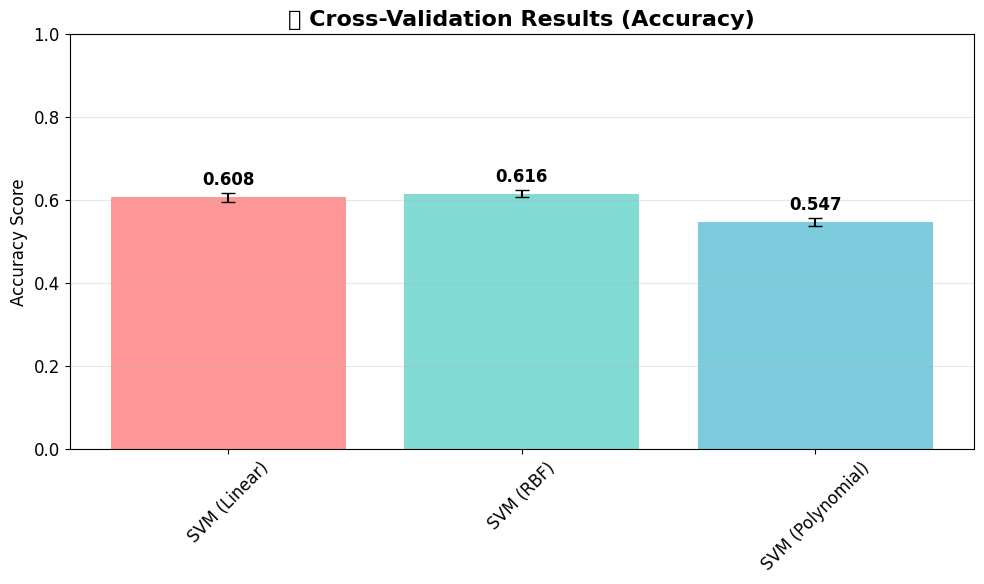

In [26]:
def perform_cross_validation(X_train_vec, y_train, cv_folds=5):
    """Perform cross-validation on different models."""
    
    print(f"🔄 Performing {cv_folds}-fold cross-validation...")
    
    models = {
        'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=42),
        'SVM (RBF)': SVC(kernel='rbf', C=1.0, random_state=42, gamma='scale'),
        'SVM (Polynomial)': SVC(kernel='poly', C=1.0, random_state=42, gamma='scale')
    }
    
    cv_results = {}
    
    for model_name, model in models.items():
        print(f"\n📊 Cross-validating {model_name}...")
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train_vec, y_train, cv=cv_folds, scoring='accuracy')
        
        cv_results[model_name] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std(),
            'scores': cv_scores
        }
        
        print(f"  - Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"  - Individual scores: {cv_scores}")
    
    return cv_results

def plot_cv_results(cv_results):
    """Plot cross-validation results."""
    
    print("📊 Creating cross-validation results visualization...")
    
    models = list(cv_results.keys())
    means = [cv_results[model]['mean'] for model in models]
    stds = [cv_results[model]['std'] for model in models]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, means, yerr=stds, capsize=5, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)
    plt.title('🎯 Cross-Validation Results (Accuracy)', fontsize=16, fontweight='bold')
    plt.ylabel('Accuracy Score', fontsize=12)
    plt.ylim(0, 1)
    
    # Add value labels
    for bar, mean, std in zip(bars, means, stds):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + std + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Perform cross-validation
cv_results = perform_cross_validation(X_train_vec, y_train, cv_folds=5)

# Plot results
plot_cv_results(cv_results)

## 13. Hyperparameter Tuning

In [29]:
def quick_model_comparison(X_train_vec, y_train, X_test_vec, y_test):
    """Quick comparison of different SVM configurations without grid search."""
    
    print("🚀 Quick SVM model comparison...")
    
    # Define models to test
    models_to_test = {
        'SVM (Linear, C=1)': SVC(kernel='linear', C=1, random_state=42),
        'SVM (Linear, C=10)': SVC(kernel='linear', C=10, random_state=42),
        'SVM (RBF, C=1)': SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
        'SVM (RBF, C=10)': SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
        'SVM (RBF, C=1, gamma=0.1)': SVC(kernel='rbf', C=1, gamma=0.1, random_state=42)
    }
    
    results = {}
    
    for model_name, model in models_to_test.items():
        print(f"\n🧪 Testing {model_name}...")
        
        # Train model
        model.fit(X_train_vec, y_train)
        
        # Evaluate on test set
        y_pred = model.predict(X_test_vec)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        print(f"  📊 Accuracy: {accuracy:.4f}")
        print(f"  📊 F1-Score: {f1:.4f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\n🏆 Best model: {best_model_name}")
    print(f"    Accuracy: {results[best_model_name]['accuracy']:.4f}")
    
    return results

# Use quick comparison instead of grid search
print("🚀 Using quick model comparison instead of grid search...")
model_results = quick_model_comparison(X_train_vec, y_train, X_test_vec, y_test)

🚀 Using quick model comparison instead of grid search...
🚀 Quick SVM model comparison...

🧪 Testing SVM (Linear, C=1)...
  📊 Accuracy: 0.6043
  📊 F1-Score: 0.5920

🧪 Testing SVM (Linear, C=10)...
  📊 Accuracy: 0.5726
  📊 F1-Score: 0.5626

🧪 Testing SVM (RBF, C=1)...
  📊 Accuracy: 0.6085
  📊 F1-Score: 0.5950

🧪 Testing SVM (RBF, C=10)...
  📊 Accuracy: 0.6090
  📊 F1-Score: 0.5965

🧪 Testing SVM (RBF, C=1, gamma=0.1)...
  📊 Accuracy: 0.6056
  📊 F1-Score: 0.5788

🏆 Best model: SVM (RBF, C=10)
    Accuracy: 0.6090


##  14. Final Model Evaluation

🏆 Evaluating SVM Quick Comparison...

🎯 Results for SVM (Linear, C=1):
  📊 Test Results:
    - Accuracy: 0.6043
    - Precision: 0.5807
    - Recall: 0.6043
    - F1-Score: 0.5920
  ⚙️ Parameters: {'kernel': 'linear', 'C': 1, 'gamma': 'scale'}

🎯 Results for SVM (Linear, C=10):
  📊 Test Results:
    - Accuracy: 0.5726
    - Precision: 0.5529
    - Recall: 0.5726
    - F1-Score: 0.5626
  ⚙️ Parameters: {'kernel': 'linear', 'C': 10, 'gamma': 'scale'}

🎯 Results for SVM (RBF, C=1):
  📊 Test Results:
    - Accuracy: 0.6085
    - Precision: 0.5852
    - Recall: 0.6085
    - F1-Score: 0.5950
  ⚙️ Parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}

🎯 Results for SVM (RBF, C=10):
  📊 Test Results:
    - Accuracy: 0.6090
    - Precision: 0.5852
    - Recall: 0.6090
    - F1-Score: 0.5965
  ⚙️ Parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'}

🎯 Results for SVM (RBF, C=1, gamma=0.1):
  📊 Test Results:
    - Accuracy: 0.6056
    - Precision: 0.5951
    - Recall: 0.6056
    - F1-Score:

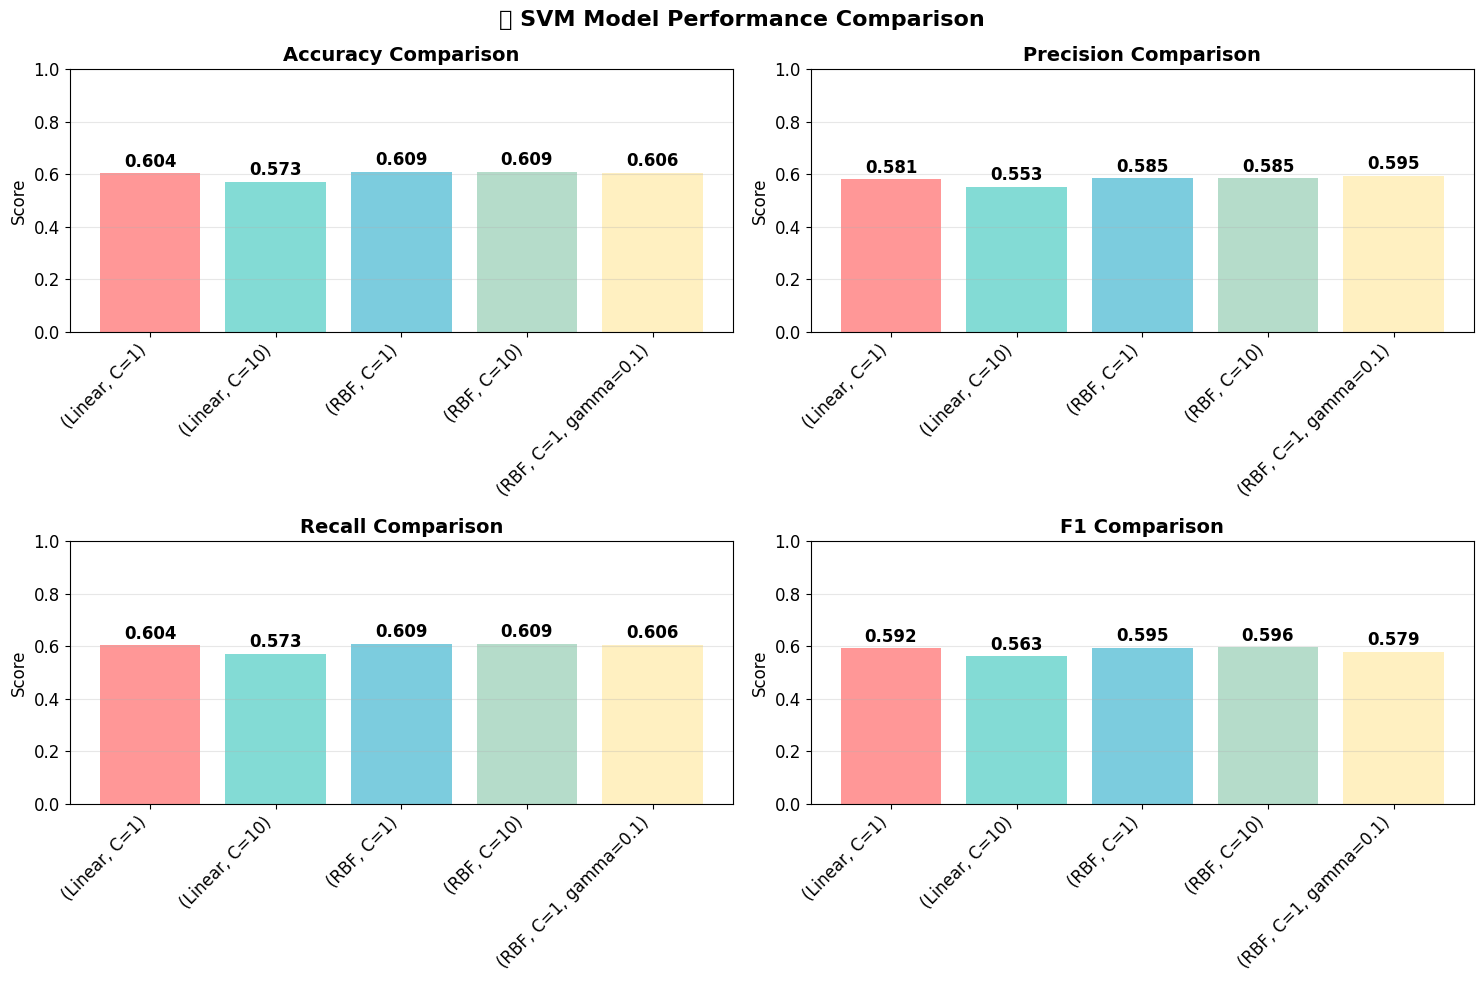

In [31]:
def evaluate_model_results(model_results, model_results_name="Quick Comparison Results"):
    """Evaluate the results from quick model comparison."""
    
    print(f"🏆 Evaluating {model_results_name}...")
    
    final_results = {}
    
    for model_name, model_info in model_results.items():
        print(f"\n🎯 Results for {model_name}:")
        
        # Extract results (they're already calculated)
        accuracy = model_info['accuracy']
        precision = model_info['precision']
        recall = model_info['recall']
        f1 = model_info['f1']
        
        # Get model parameters
        model = model_info['model']
        params = {
            'kernel': getattr(model, 'kernel', 'unknown'),
            'C': getattr(model, 'C', 'unknown'),
        }
        
        # Add gamma if it's an RBF kernel
        if hasattr(model, 'gamma'):
            params['gamma'] = model.gamma
        
        final_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'params': params
        }
        
        print(f"  📊 Test Results:")
        print(f"    - Accuracy: {accuracy:.4f}")
        print(f"    - Precision: {precision:.4f}")
        print(f"    - Recall: {recall:.4f}")
        print(f"    - F1-Score: {f1:.4f}")
        print(f"  ⚙️ Parameters: {params}")
    
    return final_results

def create_final_summary(final_results):
    """Create a final summary of all results."""
    
    print("\n🎉 FINAL RESULTS SUMMARY")
    print("=" * 50)
    
    # Find best model by accuracy
    best_model = max(final_results.keys(), 
                    key=lambda x: final_results[x]['accuracy'])
    
    print(f"🏆 Best performing model: {best_model}")
    print(f"   📊 Accuracy: {final_results[best_model]['accuracy']:.4f}")
    print(f"   ⚙️ Parameters: {final_results[best_model]['params']}")
    
    # Create comparison table
    print(f"\n📋 Complete Results Comparison:")
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 70)
    
    for model_name, results in final_results.items():
        print(f"{model_name:<20} {results['accuracy']:<10.4f} "
              f"{results['precision']:<10.4f} {results['recall']:<10.4f} "
              f"{results['f1']:<10.4f}")

def plot_model_comparison(final_results):
    """Create visualizations comparing model performance."""
    
    print("📊 Creating performance comparison plots...")
    
    models = list(final_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Prepare data
    data = {metric: [final_results[model][metric] for model in models] 
            for metric in metrics}
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for i, metric in enumerate(metrics):
        bars = axes[i].bar(range(len(models)), data[metric], 
                          color=colors[:len(models)], alpha=0.7)
        axes[i].set_title(f'{metric.capitalize()} Comparison', 
                         fontsize=14, fontweight='bold')
        axes[i].set_ylabel('Score')
        axes[i].set_ylim(0, 1)
        axes[i].set_xticks(range(len(models)))
        axes[i].set_xticklabels([model.replace('SVM ', '') for model in models], 
                               rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, data[metric]):
            axes[i].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        axes[i].grid(axis='y', alpha=0.3)
    
    plt.suptitle('🏆 SVM Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Evaluate the model results from quick comparison
final_results = evaluate_model_results(model_results, "SVM Quick Comparison")

# Create final summary
create_final_summary(final_results)

# Create performance plots
plot_model_comparison(final_results)